# Pima Indians Diabetes Regression
`sklearn` 결정 트리를 이용한 회귀
## 데이터 셋 출처
[Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)  
[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)
### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

--- 
### Data Load

In [2]:
df_pima = pd.read_csv("http://bit.ly/data-diabetes-csv")
df_pima.shape

(768, 9)

### 기본적인 학습
회귀에 대한 내용이므로, 결측치가 많았던 `Insulin`을 타겟으로 지정해 사용

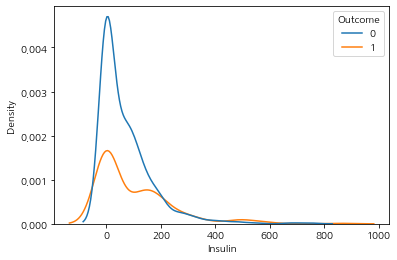

In [7]:
_ = sns.kdeplot(data=df_pima, x="Insulin", hue="Outcome")

#### 데이터 셋 나누기

In [3]:
label_name = "Insulin"

In [4]:
feature_names = df_pima.columns.tolist()
feature_names.remove(label_name)
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

`Insulin`을 예측하는 모델을 만들 예정이므로, Train 세트에는 `Insulin`의 값이 존재하는 데이터만 사용할 수 있음

In [5]:
train = df_pima[df_pima["Insulin"]>0]
test = df_pima[df_pima["Insulin"]==0]
print(f"train: {train.shape}\n test: {test.shape}")

train: (394, 9)
 test: (374, 9)


In [6]:
X_train, y_train, X_test, y_test = train[feature_names], train[label_name], test[feature_names], test[label_name]
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (394, 8)
y_train: (394,)
X_test: (374, 8)
y_test: (374,)


#### 회귀 알고리즘
결정 트리는 분류와 회귀에 모두 사용 가능한 `CART` 알고리즘이므로 결정 트리 기반의 회귀 모델을 사용함

In [8]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Cross validation (교차 검증)
모델 학습 시 데이터를 훈련용(`train`)과 검증용(`valid`)으로 선택하는 방법  
모델 성능에 직접적인 영향은 없고, 평가의 정확도를 높이는 목적으로 사용  
가장 많이 사용하는 방식은 `K-Fold Cross Validation`임  

#### 교차 검증 종류
1. Hold-out Cross-Validation: 특정 비율로 Train과 Test를 **1회**만 분할
2. K-Fold Cross-Validation: 전체를 K개로 나누고, 1개를 Test로 나머지(K-1)개를 학습용으로 사용하는 과정을 K번 반복함
3. LpOCV (Leave-p-Out Cross-Validatoin): 전체 데이터 중에서 p개의 샘플을 선택해 모델 검증에 활용
4. LOOCV (Leave-One-Out CV): LpOCV에서 `p=1`인 경우

- 장점
  - Overfitting 방지
  - 일반화된 모델 생성 가능
  - 적은 데이터에서 Underfitting 방지
- 단점
  - 소요시간 증가

In [10]:
from sklearn.model_selection import cross_val_predict
# cv: k-fold의 k, 5 -> 4개로 학습하고 1개로 검증
# n_jobs: 사용할 코어의 개수
# verbose: 로그를 얼마나 출력할 것인지
y_valid_predict = cross_val_predict(model, X_train, y_train, cv=5, n_jobs=-1, verbose=0)

In [11]:
np.sum(y_train==y_valid_predict)

3

In [12]:
np.mean(y_train==y_valid_predict)

0.007614213197969543

정답을 3개 밖에 맞추지 못했습니다..  정답률은 약 0.008%로 굉장히 낮습니다.

### 잔차(residual) 구하기
잔차를 시각화해봅니다

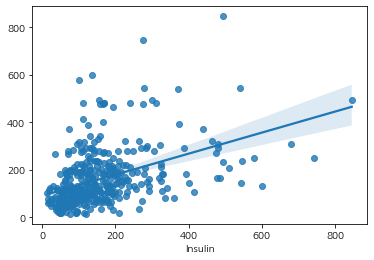

In [13]:
_ = sns.regplot(x=y_train, y=y_valid_predict)

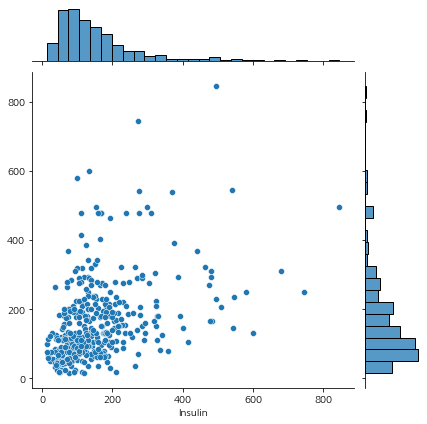

In [14]:
_ = sns.jointplot(x=y_train, y=y_valid_predict)

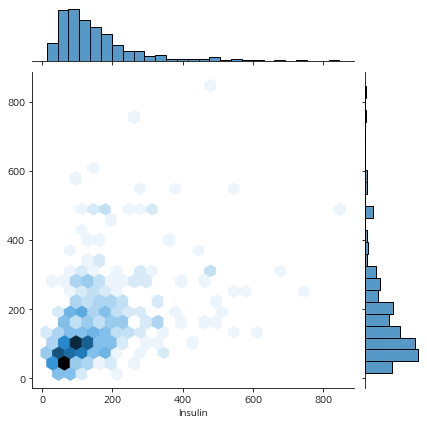

In [15]:
_ = sns.jointplot(x=y_train, y=y_valid_predict, kind="hex")

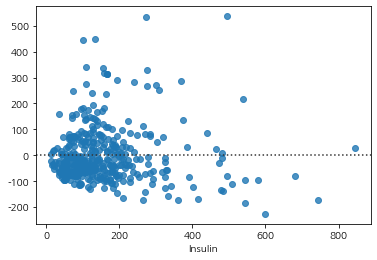

In [ ]:
_ = sns.residplot(x=y_train, y=y_valid_predict)

`residplot`에서, 0은 추정치와 실제값의 차이가 없는 것을 의미하므로 0에 가까울수록 잘 예측한 값임

### 회귀를 측정하는 방식
#### R2_score
R2 score는 회귀 모델이 얼마나 설명력이 있느냐를 의미하며, 실제값의 분산 대비 예측값의 분산 비율이라고 이해 가능함  
1에 가까울수록 좋은 성능을 가졌다고 해석할 수 있음 

In [17]:
from sklearn.metrics import r2_score

r2_score(y_train, y_valid_predict)

-0.14429295602725567

In [19]:
df_y = pd.DataFrame({"y_train": y_train, "y_valid_predict": y_valid_predict})
df_y.head()

,y_train,y_valid_predict
3,94,25.0
4,168,480.0
6,88,55.0
8,543,145.0
13,846,495.0


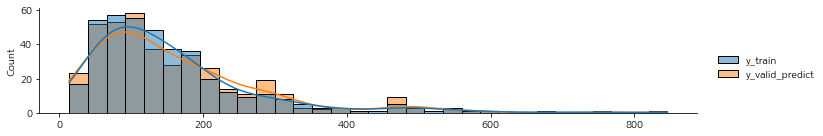

In [36]:
# 정답값과 예측값의 분포
_ = sns.displot(df_y, height=2, aspect=5, kde=True)

#### 오차

In [25]:
# 오차에서 부호에 의미를 부여 가능하지만, 큰 의미가 없으므로 절대값을 사용
error = y_train - y_valid_predict
abs(error).describe()

count    394.000000
mean      86.571066
std       92.896321
min        0.000000
25%       22.250000
50%       55.000000
75%      115.000000
max      495.000000
Name: Insulin, dtype: float64

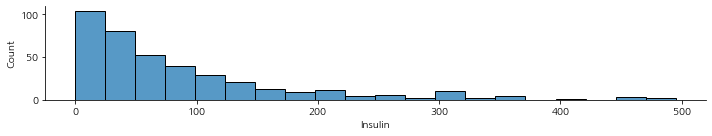

In [26]:
# 오차값의 분포
_ = sns.displot(abs(error), height=2, aspect=5)

#### MAE(Mean Absolut Error)
평균 절대 오차라고하며, 평균 절대 편차/차이와는 다른 개념임  
$ MAE = {\sum_{i=1}^n err_i \over n }$

In [37]:
abs(error).mean()

86.57106598984771

#### MAPE (Mean Absolute Percentage Error)
평균 절대비 오차라하며, 퍼센트 값을 가짐  
0에 가까울수록 회귀 모형의 성능이 좋다고 해석 가능  
평균 절대 백분율 편차 (MAPD)라고도 함  
$ MAPE = {100\% \over n} \sum_{t=1}^n |{y-\hat y \over y}| $

In [38]:
abs(error/y_train).mean()

0.687125648313691

#### MSE (Mean Squared Error)
평균 제곱 오차라하며, 제곱을 이용해 음수를 양수로 변환  
$ MSE = {1 \over n} \sum_{i=1}^n (\hat y_i - y_i)^2 $

In [39]:
np.square(error).mean()

16102.373096446701

#### RMSE (Root Mean Squared Error)
평균 제곱근 편차라하며, 정밀도를 표현하는데 적합  
$ RMSE = \sqrt{MSE} $

In [40]:
np.sqrt(np.square(error).mean())

126.89512636995443

### 트리 알고리즘 분석

In [41]:
model.feature_importances_

array([4.20201517e-02, 4.08219914e-01, 6.24932543e-02, 5.97519119e-02,
       1.10296456e-01, 1.63917473e-01, 1.52984660e-01, 3.16179009e-04])

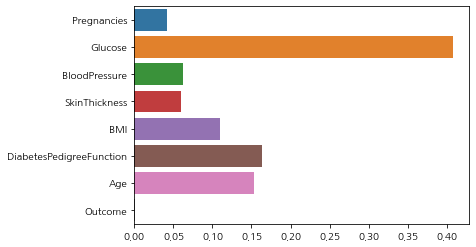

In [42]:
_ = sns.barplot(x=model.feature_importances_, y=feature_names)

### 예측
회귀에서 사용한 `cross-validation`은 예측을 진행한것이 아니라, 모델 성능을 높이기 위해 진행한 과정임

In [43]:
y_predict = model.predict(X_test)

In [44]:
# 기존 Insulin 수치
train.groupby("Outcome")["Insulin"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,264.0,130.287879,102.482237,15.0,66.0,102.5,161.25,744.0
1,130.0,206.846154,132.699898,14.0,127.5,169.5,239.25,846.0


In [50]:
# 예측한 값으로 Insulin 값을 채운 경우
test["Insulin"] = y_predict
test.groupby("Outcome")["Insulin"].describe()

C:\Users\spec3\AppData\Local\Temp\ipykernel_2332\112996873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Insulin"] = y_predict


,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,133.161017,102.224032,15.0,64.0,99.5,158.25,600.0
1,138.0,212.434783,141.952236,44.0,115.0,176.0,267.00,846.0


평균값만 봤을때는 큰차이가 없음